In [1]:
import os
import sys
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tqdm import tqdm_notebook as tqdm
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Activation, Input
from keras.models import Model, load_model
from keras.utils import to_categorical
from keras.optimizers import SGD, RMSprop
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras import regularizers

# from google.colab import drive
# drive.mount("/content/gdrive")

Using TensorFlow backend.


In [2]:
import keras
print(keras.__version__)

from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())

2.2.4
['/job:localhost/replica:0/task:0/device:GPU:0']


In [3]:
drive_base_path = "../"
path_to_images = drive_base_path + "dataset/ISIC2018_Training_Input/"
path_to_balanced_images = drive_base_path + "dataset/Balanced_Training_Input_Aug/"
path_to_image_save = drive_base_path + "dataset/sample_images/"

In [4]:
NAME = "VGG16_%s" % (int(time.time()))
tensorboard = TensorBoard(log_dir='./logs/%s' % (NAME))

In [5]:
filepath = drive_base_path + "models/checkpoint/VGG16.{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [6]:
def load_sample(path_to_images, number_of_images):
    list_of_images = os.listdir(path_to_images)
    x = []
    for i, filename in enumerate(list_of_images):
        image = cv2.imread(path_to_images + filename)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        x.append(image)
        
        if i >= number_of_images:
            break
    
    x = np.array(x)
    return x       

In [7]:
x = load_sample(path_to_images, 1000)
print(x.shape)

(1001, 450, 600, 3)


In [8]:
datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
    preprocessing_function=preprocess_input,
    rotation_range=30,
    zoom_range=0.2,
    fill_mode='constant',
    cval=0,
    validation_split=0.1,
    data_format="channels_last")

In [9]:
datagen.fit(x)

In [14]:
classes = ['mel', 'nv', 'bcc', 'akiec', 'bkl', 'df', 'vasc']
batch_size = 16
train_generator = datagen.flow_from_directory(
                    directory=path_to_balanced_images,
                    target_size=(224, 224),
                    batch_size=batch_size,
                    classes=classes,
                    shuffle=True,
                    subset='training')

validation_generator = datagen.flow_from_directory(
                    directory=path_to_balanced_images,
                    target_size=(224, 224),
                    batch_size=batch_size,
                    classes=classes,
                    shuffle=True,
                    subset='validation')

Found 29871 images belonging to 7 classes.
Found 3317 images belonging to 7 classes.


In [15]:
train_samples = train_generator.samples
valid_samples = validation_generator.samples

In [13]:
_x, _y = next(train_generator)

In [16]:
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)

print(class_weights)

[1.06495775 0.7070896  1.08196899 1.11533866 1.07841438 1.03074534
 1.07705344]


# DEFINING THE MODEL

In [17]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(4096, 
          kernel_regularizer=regularizers.l2(5e-4),
          activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, 
          kernel_regularizer=regularizers.l2(5e-4),
          activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

# for layer in model.layers:
#     print(layer, layer.trainable)

model.compile(loss="categorical_crossentropy", 
              optimizer=RMSprop(lr=1e-5), 
              metrics=["acc"])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [18]:
epochs = 6
history = model.fit_generator(train_generator, 
                              steps_per_epoch=train_samples / batch_size,
                              validation_data=validation_generator,
                              validation_steps=valid_samples / batch_size,
                              epochs=epochs,
#                               class_weight=class_weights,
                              verbose=1,
                              callbacks=[tensorboard, checkpoint])

Epoch 1/6
1867/1866 [==============================] - 625s 335ms/step - loss: 9.3590 - acc: 0.4059 - val_loss: 5.3549 - val_acc: 0.5930

Epoch 00001: val_acc improved from -inf to 0.59301, saving model to ../models/checkpoint/VGG16.01-0.59.hdf5
Epoch 2/6
1867/1866 [==============================] - 617s 330ms/step - loss: 5.7022 - acc: 0.5241 - val_loss: 4.2323 - val_acc: 0.6247

Epoch 00002: val_acc improved from 0.59301 to 0.62466, saving model to ../models/checkpoint/VGG16.02-0.62.hdf5
Epoch 3/6
1867/1866 [==============================] - 617s 330ms/step - loss: 4.3244 - acc: 0.5749 - val_loss: 3.5169 - val_acc: 0.6364

Epoch 00003: val_acc improved from 0.62466 to 0.63642, saving model to ../models/checkpoint/VGG16.03-0.64.hdf5
Epoch 4/6
1867/1866 [==============================] - 616s 330ms/step - loss: 3.4664 - acc: 0.6155 - val_loss: 2.9879 - val_acc: 0.6415

Epoch 00004: val_acc improved from 0.63642 to 0.64154, saving model to ../models/checkpoint/VGG16.04-0.64.hdf5
Epoch 5

### Load model from checkpoint

In [15]:
filepath = drive_base_path + "models/checkpoint/VGG16.06-0.62.hdf5"
model = load_model(filepath)

In [16]:
NAME = "VGG16_%s" % (int(time.time()))
tensorboard = TensorBoard(log_dir='./logs/%s' % (NAME))

In [17]:
epochs = 3
history = model.fit_generator(train_generator, 
                              steps_per_epoch=train_samples / batch_size,
                              validation_data=validation_generator,
                              validation_steps=valid_samples / batch_size,
                              epochs=epochs,
#                               class_weight=class_weights,
                              verbose=1,
                              callbacks=[tensorboard, checkpoint])

Epoch 1/3
1867/1866 [==============================] - 611s 328ms/step - loss: 2.0676 - acc: 0.6209 - val_loss: 1.9666 - val_acc: 0.6289

Epoch 00001: val_acc improved from 0.61501 to 0.62888, saving model to ../models/checkpoint/VGG16.01-0.63.hdf5
Epoch 2/3
1867/1866 [==============================] - 607s 325ms/step - loss: 1.8007 - acc: 0.6439 - val_loss: 1.8328 - val_acc: 0.6219

Epoch 00002: val_acc did not improve from 0.62888
Epoch 3/3
1867/1866 [==============================] - 607s 325ms/step - loss: 1.6238 - acc: 0.6535 - val_loss: 1.7554 - val_acc: 0.6376

Epoch 00003: val_acc improved from 0.62888 to 0.63762, saving model to ../models/checkpoint/VGG16.03-0.64.hdf5


### Fine Tuning the model

In [20]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

# for layer in model.layers[:11]:
#     layer.trainable = False
for layer in model.layers:
    layer.trainable = True

for layer in model.layers:
    print(layer, layer.trainable)


<keras.engine.input_layer.InputLayer object at 0x7fea31734048> True
<keras.layers.convolutional.Conv2D object at 0x7fea31734198> True
<keras.layers.convolutional.Conv2D object at 0x7fea317342e8> True
<keras.layers.pooling.MaxPooling2D object at 0x7fea30b76320> True
<keras.layers.convolutional.Conv2D object at 0x7fea30b76f60> True
<keras.layers.convolutional.Conv2D object at 0x7fea30bdb3c8> True
<keras.layers.pooling.MaxPooling2D object at 0x7fea30c32860> True
<keras.layers.convolutional.Conv2D object at 0x7fea30c326d8> True
<keras.layers.convolutional.Conv2D object at 0x7fea30c26160> True
<keras.layers.convolutional.Conv2D object at 0x7fea30be4400> True
<keras.layers.pooling.MaxPooling2D object at 0x7fea30c08860> True
<keras.layers.convolutional.Conv2D object at 0x7fea30c086d8> True
<keras.layers.convolutional.Conv2D object at 0x7fea30b4f160> True
<keras.layers.convolutional.Conv2D object at 0x7fea32f2f400> True
<keras.layers.pooling.MaxPooling2D object at 0x7fea32f48860> True
<keras.l

In [15]:
filepath = drive_base_path + "models/checkpoint/VGG16.03-0.64.hdf5"
model = load_model(filepath)

In [21]:
filepath = drive_base_path + "models/checkpoint/VGG_REST.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [22]:
NAME = "VGG16_REST_%s" % (int(time.time()))
tensorboard = TensorBoard(log_dir='./logs/%s' % (NAME))

In [23]:
model.compile(optimizer=SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=["acc"])
epochs = 15
history = model.fit_generator(train_generator, 
                              steps_per_epoch=train_samples / batch_size,
                              validation_data=validation_generator,
                              validation_steps=valid_samples / batch_size,
#                               class_weight=class_weights,
                              epochs=epochs,
                              verbose=1,
                              callbacks=[tensorboard, checkpoint])
model.save_weights(drive_base_path + 'models/VGG16_AUG_ISIC_cnn.h5')
# model.evaluate(X_test, y_test)

Epoch 1/15
1867/1866 [==============================] - 1105s 592ms/step - loss: 1.9677 - acc: 0.7329 - val_loss: 2.0262 - val_acc: 0.7232

Epoch 00001: val_acc improved from -inf to 0.72324, saving model to ../models/checkpoint/VGG_REST.01-2.03.hdf5
Epoch 2/15
1867/1866 [==============================] - 1096s 587ms/step - loss: 1.6804 - acc: 0.8299 - val_loss: 2.0347 - val_acc: 0.7341

Epoch 00002: val_acc improved from 0.72324 to 0.73410, saving model to ../models/checkpoint/VGG_REST.02-2.03.hdf5
Epoch 3/15
1867/1866 [==============================] - 1095s 586ms/step - loss: 1.5748 - acc: 0.8686 - val_loss: 1.9511 - val_acc: 0.7670

Epoch 00003: val_acc improved from 0.73410 to 0.76696, saving model to ../models/checkpoint/VGG_REST.03-1.95.hdf5
Epoch 4/15
1867/1866 [==============================] - 1094s 586ms/step - loss: 1.4988 - acc: 0.8977 - val_loss: 1.9111 - val_acc: 0.7860

Epoch 00004: val_acc improved from 0.76696 to 0.78595, saving model to ../models/checkpoint/VGG_REST.

KeyboardInterrupt: 

# ACCURACY AND LOSS PLOTS

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


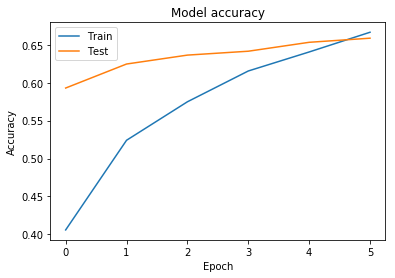

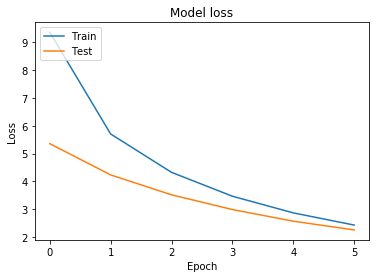

In [24]:
# Plot Training and Validation Accuracy
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# CONFUSION MATRIX

In [25]:
classes = ['mel', 'nv', 'bcc', 'akiec', 'bkl', 'df', 'vasc']
validation_generator = datagen.flow_from_directory(
                    directory=path_to_balanced_images,
                    target_size=(224, 224),
                    batch_size=1,
                    classes=classes,
                    shuffle=False,
                    subset='validation')

Found 3317 images belonging to 7 classes.


In [26]:
filepath = drive_base_path + "models/checkpoint/VGG_REST.09-2.09.hdf5"
model.load_weights(filepath)

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

Y_pred = model.predict_generator(validation_generator, steps=valid_samples / 1)
y_pred = np.argmax(Y_pred, axis=1)

In [28]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix


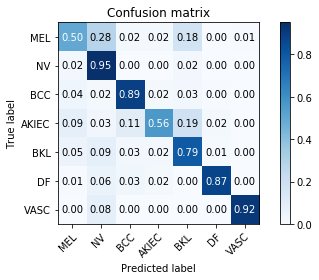

In [29]:
class_names = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]
plot_confusion_matrix(validation_generator.classes, y_pred, classes=class_names, title='Confusion matrix', normalize=True)
plt.show()

# ISIC LIVE IMAGE TEST/VALIDATION DATA

In [39]:
# TESTTING ON ISIC LIVE IMAGE DATA
path_to_images = drive_base_path + "dataset/ISIC2018_Task3_Test_Input/"

In [40]:
def preprocess_images(path_to_images):
    images_list = []
    filename_list = []
    
    path_to_images = path_to_images + 'test/'
    
    input_size = 224
    list_of_images = os.listdir(path_to_images)
    number = len(list_of_images)
    
    for filename in tqdm(list_of_images, total=number):
        filename_list.append(filename[:-4])
        
        image = cv2.imread(path_to_images + filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        old_size = image.shape[:2] # height, width

        ratio = float(input_size)/max(old_size)
        new_size = tuple([int(x*ratio) for x in old_size])

        image = cv2.resize(image, (new_size[1], new_size[0]))
        delta_w = input_size - new_size[1]
        delta_h = input_size - new_size[0]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)

        color = [0, 0, 0]
        new_img = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, 
                                    value=color)

        images_list.append(new_img)
        
    images_list = np.array(images_list)
    filename_list = np.array(filename_list)
    filename_list = filename_list[:, None]
    return (images_list, filename_list)

In [41]:
x_test, names = preprocess_images(path_to_images)

(1512, 224, 224, 3)
(1512, 1)


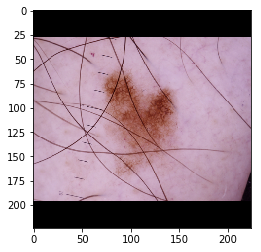

In [42]:
print(x_test.shape)
print(names.shape)
plt.imshow(x_test[5])

In [48]:
test_datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
    preprocessing_function=preprocess_input,
    data_format="channels_last")

In [49]:
test_datagen.fit(x_test)

In [50]:
test_generator = test_datagen.flow(
                    x_test,
                    batch_size=1,
                    shuffle=False)

In [51]:
model.load_weights(drive_base_path + 'models/checkpoint/VGG_REST.09-2.09.hdf5')

In [52]:
predictions = model.predict_generator(test_generator, steps=len(x_test))
# classes = (predictions > 0.5).astype(np.float)
# print(classes.shape)

In [53]:
print(predictions.shape)

(1512, 7)


In [54]:
final_output = np.concatenate((names, predictions), axis=1)
final_output.shape

(1512, 8)

In [55]:
import csv

with open(drive_base_path + "output.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["image", "MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"])
    writer.writerows(final_output)